In [1]:
%matplotlib inline

In [2]:
# !pip install torch

In [26]:
!pip install torchvision

In [1]:
import time
import os
import copy

# PyTorch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision
from torchvision import datasets, transforms
import torch.utils.data as data_utils
from torch.autograd import Variable

# Pennylane
import pennylane as qml
from pennylane import numpy as np

torch.manual_seed(42)
np.random.seed(42)

# Plotting
import matplotlib.pyplot as plt

# OpenMP: number of parallel threads.
os.environ["OMP_NUM_THREADS"] = "1"

In [2]:
n_qubits = 4                
step = 0.0004               
batch_size = 4              
num_epochs = 30              
q_depth = 6                 
gamma_lr_scheduler = 0.1   
q_delta = 0.01    

# Initial spread of random quantum weights
start_time = time.time()    # Початок відліку часу

In [3]:
dev = qml.device("default.qubit", wires=n_qubits)


In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [31]:
! mkdir hymenoptera_data
! ls

mkdir: cannot create directory ‘hymenoptera_data’: File exists
Untitled.ipynb	       Untitled1.ipynb	 hymenoptera_data.zip
Untitled1-Copy1.ipynb  data		 hymenoptera_data.zip.1
Untitled1-Copy2.ipynb  hymenoptera_data  quanvolution


In [32]:
# ! wget https://download.pytorch.org/tutorial/hymenoptera_data.zip
# ! cp ./hymenoptera_data.zip hymenoptera_data
# ! unzip hymenoptera_data/hymenoptera_data.zip
# ! ls -all hymenoptera_data

In [5]:
# завантаження датасету Бджіл та мурах

data_transforms = {
    "train": transforms.Compose(
        [
            # transforms.RandomResizedCrop(224),     # параметр для аугментації
            # transforms.RandomHorizontalFlip(),     # параметр для аугментації
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
        ]
    ),
    "val": transforms.Compose(
        [
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
        ]
    ),
}


data_dir = "hymenoptera_data"
image_datasets = {
    x if x == "train" else "validation": datasets.ImageFolder(
        os.path.join(data_dir, x), data_transforms[x]
    )
    for x in ["train", "val"]
}
dataset_sizes = {x: len(image_datasets[x]) for x in ["train", "validation"]}
class_names = image_datasets["train"].classes

# Ініціалізація декодера
dataloaders = {
    x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True)
    for x in ["train", "validation"]
}

# функція для відображення рисунків
def imshow(inp, title=None):
    """Display image from tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    # інверсія нормалізації
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)

In [6]:
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'


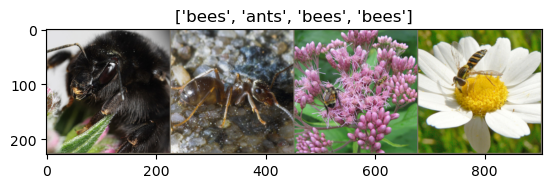

In [7]:
# береться шматок даних
inputs, classes = next(iter(dataloaders["validation"]))

# з нього формується сітка
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

dataloaders = {
    x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True)
    for x in ["train", "validation"]
}

Files already downloaded and verified
Files already downloaded and verified


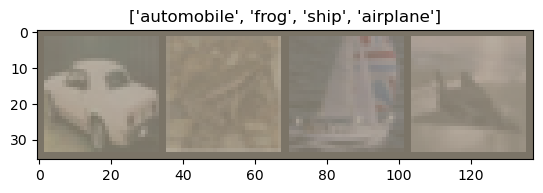

In [8]:
# завантаження датасету CIFAR10

training_data = datasets.CIFAR10(
    root="data",
    train=True,
    download=True,
    transform=transforms.ToTensor()
)
test_data = datasets.CIFAR10(
    root="data",
    train=False,
    download=True,
    transform=transforms.ToTensor()
)
indices = torch.arange(1000)
class_names_CIFAR =training_data.classes
train_100 = data_utils.Subset(training_data, indices)
test_100 = data_utils.Subset(test_data, indices)


image_datasets_CIFAR = {"train": train_100, "validation": test_100}

dataset_sizes_CIFAR = {x: len(image_datasets_CIFAR[x]) for x in ["train", "validation"]}


dataloaders_CIFAR = {
    x: torch.utils.data.DataLoader(image_datasets_CIFAR[x], batch_size=batch_size, shuffle=True)
    for x in ["train", "validation"]
}

inputs_CIFAR, classes_CIFAR = next(iter(dataloaders_CIFAR["validation"]))
out_CIFAR = torchvision.utils.make_grid(inputs_CIFAR)

imshow(out_CIFAR, title=[class_names_CIFAR[x] for x in classes_CIFAR])


dataloaders_CIFAR = {
    x: torch.utils.data.DataLoader(image_datasets_CIFAR[x], batch_size=batch_size, shuffle=True)
    for x in ["train", "validation"]
}

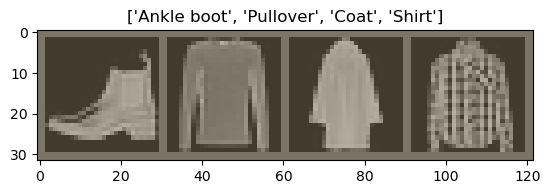

In [9]:
# завантаження датасету FashionMNIST

data_transforms = {
    'train': transforms.Compose([
        #transforms.Resize(28),
        transforms.RandomHorizontalFlip(),
        transforms.Grayscale(3), 
        transforms.ToTensor(), 
        transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
    ]),
    'test': transforms.Compose([
        #transforms.Resize(28),
        transforms.Grayscale(3),
        transforms.ToTensor(), 
        transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
    ])
}


training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=data_transforms['train']
)
test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=data_transforms['test']
)
indices = torch.arange(1000)
class_names_FMNIST =training_data.classes
train_100 = data_utils.Subset(training_data, indices)
test_100 = data_utils.Subset(test_data, indices)


image_datasets_FMNIST = {"train": train_100, "validation": test_100}

dataset_sizes_FMNIST = {x: len(image_datasets_FMNIST[x]) for x in ["train", "validation"]}


dataloaders_FMNIST = {
    x: torch.utils.data.DataLoader(image_datasets_FMNIST[x], batch_size=batch_size, shuffle=True)
    for x in ["train", "validation"]
}


inputs_FMNIST, classes_FMNIST = next(iter(dataloaders_FMNIST["validation"]))
out_FMNIST = torchvision.utils.make_grid(inputs_FMNIST)

imshow(out_FMNIST, title=[class_names_FMNIST[x] for x in classes_FMNIST])


dataloaders_FMNIST = {
    x: torch.utils.data.DataLoader(image_datasets_FMNIST[x], batch_size=batch_size, shuffle=True)
    for x in ["train", "validation"]
}

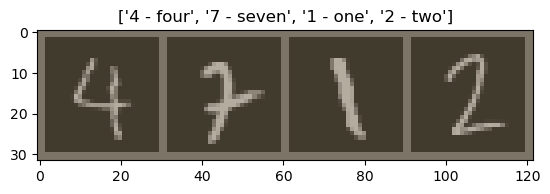

In [10]:
# завантаження датасету MNIST

training_data = datasets.MNIST(
    root="data",
    train=True,
    download=True,
    transform=data_transforms['train']
)
test_data = datasets.MNIST(
    root="data",
    train=False,
    download=True,
    transform=data_transforms['test']
)
indices = torch.arange(1000)
class_names_MNIST =training_data.classes
train_100 = data_utils.Subset(training_data, indices)
test_100 = data_utils.Subset(test_data, indices)


image_datasets_MNIST = {"train": train_100, "validation": test_100}

dataset_sizes_MNIST = {x: len(image_datasets_MNIST[x]) for x in ["train", "validation"]}


dataloaders_MNIST = {
    x: torch.utils.data.DataLoader(image_datasets_MNIST[x], batch_size=batch_size, shuffle=True)
    for x in ["train", "validation"]
}


inputs_MNIST, classes_MNIST = next(iter(dataloaders_MNIST["validation"]))
out_MNIST = torchvision.utils.make_grid(inputs_MNIST)

imshow(out_MNIST, title=[class_names_MNIST[x] for x in classes_MNIST])


dataloaders_MNIST = {
    x: torch.utils.data.DataLoader(image_datasets_MNIST[x], batch_size=batch_size, shuffle=True)
    for x in ["train", "validation"]
}

In [17]:
class DressedQuantumNet(nn.Module):
    """
    
    Модель бібліотеки Torch для імпелементації "вдягенної" квантомної мережі
    """

    def __init__(self, outpun_length):
        """
        Визначення "вдягненого" порядку
        """

        super().__init__()
        self.pre_net = nn.Linear(512, n_qubits)
        self.q_params = nn.Parameter(q_delta * torch.randn(q_depth * n_qubits))
        self.post_net = nn.Linear(n_qubits, outpun_length)

    def forward(self, input_features):
        """
        Визначення того, як тенсори повинні рухатись мережею
        """


        # із зменшенням кількості параметрів для оброки ми спрощуємо для моделі процесс навчання
        pre_out = self.pre_net(input_features)
        q_in = torch.tanh(pre_out) * np.pi / 2.0

        # Використовуємо quantum circuit для кожного елементу групи і додаємо його в кінцеву структруру
        q_out = torch.Tensor(0, n_qubits)
        q_out = q_out.to(device)
        for elem in q_in:
            q_out_elem = torch.tensor(quantum_net(elem, self.q_params)).float().unsqueeze(0)
            q_out = torch.cat((q_out, q_out_elem))

        # повертаємо передбачення в двувимірному вигляді
        return self.post_net(q_out)


In [18]:
def H_layer(nqubits):
    """Шар single-qubit воріт Hadamard.
    """
    for idx in range(nqubits):
        qml.Hadamard(wires=idx)


def RY_layer(w):
    """Шар параметрованого qubit-у ротаціїв проекції У
    """
    for idx, element in enumerate(w):
        qml.RY(element, wires=idx)


def entangling_layer(nqubits):
    """Шар CNOTs і за ним ще один шар CNOT в шахматному порядку
    """
    for i in range(0, nqubits - 1, 2):  # Loop over even indices: i=0,2,...N-2
        qml.CNOT(wires=[i, i + 1])
    for i in range(1, nqubits - 1, 2):  # Loop over odd indices:  i=1,3,...N-3
        qml.CNOT(wires=[i, i + 1])

In [19]:
@qml.qnode(dev, interface="torch")
def quantum_net(q_input_features, q_weights_flat):
    """
    Варіаційний quantum circuit.
    """

    # переформування ваг
    q_weights = q_weights_flat.reshape(q_depth, n_qubits)

    # Start from state |+> , unbiased w.r.t. |0> and |1>
    H_layer(n_qubits)

    # Виділені особливості в quantum node
    RY_layer(q_input_features)

    # Ланцюг тренувальних шарів з кубітів
    for k in range(q_depth):
        entangling_layer(n_qubits)
        RY_layer(q_weights[k])

    exp_vals = [qml.expval(qml.PauliZ(position)) for position in range(n_qubits)]
    return exp_vals
    #return tuple(exp_vals)

In [20]:
def def_model_hybrid(output_length):
  model_hybrid = torchvision.models.resnet18(pretrained=True)

  """ Мережі на яких проводилось тестування
  """
  # alexnet = models.alexnet(pretrained=True)
  # mobilenet_v2 = models.mobilenet_v2(pretrained=True)
  # mobilenet_v3_small = models.mobilenet_v3_small(pretrained=True)
  # efficientnet_b0 = models.efficientnet_b0(pretrained=True)
  # convnext_tiny = models.convnext_tiny(pretrained=True)


  # vit_b_16 = models.vit_b_16(pretrained=True)
  # vit_b_32 = models.vit_b_32(pretrained=True)
  # vit_l_16 = models.vit_l_16(pretrained=True)
  # vit_l_32 = models.vit_l_32(pretrained=True)

  for param in model_hybrid.parameters():
      param.requires_grad = False


  model_hybrid.fc = DressedQuantumNet(output_length)

  # Use CUDA or CPU according to the "device" object.
  model_hybrid = model_hybrid.to(device)

  criterion = nn.CrossEntropyLoss()
  optimizer_hybrid = optim.Adam(model_hybrid.fc.parameters(), lr=step)
  exp_lr_scheduler = lr_scheduler.StepLR(
      optimizer_hybrid, step_size=10, gamma=gamma_lr_scheduler
  )

  return [model_hybrid, criterion, optimizer_hybrid, exp_lr_scheduler]

In [21]:
# Послідовність тренування моделі
def train_model(model_arr, num_epochs, dataloaders, dataset_sizes):
    model, criterion, optimizer, scheduler = model_arr
    since = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    best_loss = 10000.0  
    best_acc_train = 0.0
    best_loss_train = 10000.0  
    print("Training started:")
    hist_data = {"acc": [], "loss": []}
    

    for epoch in range(num_epochs):

        for phase in ["train", "validation"]:
            if phase == "train":
                model.train()
            else:
                model.eval()
            running_loss = 0.0
            running_corrects = 0

            n_batches = dataset_sizes[phase] // batch_size
            it = 0
            for inputs, labels in dataloaders[phase]:
                since_batch = time.time()
                batch_size_ = len(inputs)
                inputs = inputs.to(device)
                labels = labels.to(device)
                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == "train"):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    if phase == "train":
                        loss = Variable(loss, requires_grad = True)
                        loss.backward()
                        optimizer.step()
                
                running_loss += loss.item() * batch_size_
                batch_corrects = torch.sum(preds == labels.data).item()
                running_corrects += batch_corrects
                print(
                    "Phase: {} Epoch: {}/{} Iter: {}/{} Batch time: {:.4f}".format(
                        phase,
                        epoch + 1,
                        num_epochs,
                        it + 1,
                        n_batches + 1,
                        time.time() - since_batch,
                    ),
                    end="\r",
                    flush=True,
                )
                it += 1

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects / dataset_sizes[phase]
            if phase != "train":
              hist_data["acc"].append(epoch_acc)
              hist_data["loss"].append(epoch_loss)

            print(
                "Phase: {} Epoch: {}/{} Loss: {:.4f} Acc: {:.4f}        ".format(
                    "train" if phase == "train" else "validation  ",
                    epoch + 1,
                    num_epochs,
                    epoch_loss,
                    epoch_acc,
                )
            )


            if phase == "validation" and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == "validation" and epoch_loss < best_loss:
                best_loss = epoch_loss
            if phase == "train" and epoch_acc > best_acc_train:
                best_acc_train = epoch_acc
            if phase == "train" and epoch_loss < best_loss_train:
                best_loss_train = epoch_loss
      
            # Update learning rate
            if phase == "train":
                scheduler.step()

    model.load_state_dict(best_model_wts)
    time_elapsed = time.time() - since
    print(
        "Training completed in {:.0f}m {:.0f}s".format(time_elapsed // 60, time_elapsed % 60)
    )
    print("Best test loss: {:.4f} | Best test accuracy: {:.4f}".format(best_loss, best_acc))
    return model, hist_data

In [22]:
from torch.utils.data import dataset

# тренування моделей
model_hybrid, data_bees = train_model(
    def_model_hybrid(len(class_names)),
    num_epochs=num_epochs, 
    dataloaders=dataloaders, 
    dataset_sizes=dataset_sizes
)

model_hybrid_CIFAR, data_CIFAR = train_model(
    def_model_hybrid(len(class_names_CIFAR)), 
    num_epochs=num_epochs, 
    dataloaders=dataloaders_CIFAR, 
    dataset_sizes=dataset_sizes_CIFAR
)

model_hybrid_FMNIST, data_FMNIST = train_model(
    def_model_hybrid(len(class_names_FMNIST)), 
    num_epochs=num_epochs, 
    dataloaders=dataloaders_FMNIST, 
    dataset_sizes=dataset_sizes_FMNIST
)

model_hybrid_MNIST, data_MNIST = train_model(
    def_model_hybrid(len(class_names_MNIST)), 
    num_epochs=num_epochs, 
    dataloaders=dataloaders_MNIST, 
    dataset_sizes=dataset_sizes_MNIST
)



Training started:
Phase: train Epoch: 1/30 Loss: 0.7372 Acc: 0.4959        
Phase: validation   Epoch: 1/30 Loss: 0.7336 Acc: 0.5425        
Phase: train Epoch: 2/30 Loss: 0.7367 Acc: 0.4959        
Phase: validation   Epoch: 2/30 Loss: 0.7327 Acc: 0.5425        
Phase: train Epoch: 3/30 Loss: 0.7408 Acc: 0.4959        
Phase: validation   Epoch: 3/30 Loss: 0.7303 Acc: 0.5425        
Phase: train Epoch: 4/30 Loss: 0.7374 Acc: 0.4959        
Phase: validation   Epoch: 4/30 Loss: 0.7328 Acc: 0.5425        
Phase: train Epoch: 5/30 Loss: 0.7388 Acc: 0.4959        
Phase: validation   Epoch: 5/30 Loss: 0.7340 Acc: 0.5425        
Phase: train Epoch: 6/30 Loss: 0.7394 Acc: 0.4959        
Phase: validation   Epoch: 6/30 Loss: 0.7335 Acc: 0.5425        
Phase: train Epoch: 7/30 Loss: 0.7380 Acc: 0.4959        
Phase: validation   Epoch: 7/30 Loss: 0.7370 Acc: 0.5425        
Phase: train Epoch: 8/30 Loss: 0.7392 Acc: 0.4959        
Phase: validation   Epoch: 8/30 Loss: 0.7318 Acc: 0.5425       

Phase: train Epoch: 5/30 Loss: 2.4439 Acc: 0.0960        
Phase: validation   Epoch: 5/30 Loss: 2.4396 Acc: 0.1000        
Phase: train Epoch: 6/30 Loss: 2.4299 Acc: 0.0980        
Phase: validation   Epoch: 6/30 Loss: 2.4610 Acc: 0.0960        
Phase: train Epoch: 7/30 Loss: 2.4409 Acc: 0.1020        
Phase: validation   Epoch: 7/30 Loss: 2.4528 Acc: 0.1060        
Phase: train Epoch: 8/30 Loss: 2.4515 Acc: 0.0960        
Phase: validation   Epoch: 8/30 Loss: 2.4606 Acc: 0.1070        
Phase: train Epoch: 9/30 Loss: 2.4614 Acc: 0.0780        
Phase: validation   Epoch: 9/30 Loss: 2.4562 Acc: 0.1070        
Phase: train Epoch: 10/30 Loss: 2.4312 Acc: 0.0900        
Phase: validation   Epoch: 10/30 Loss: 2.4596 Acc: 0.1010        
Phase: train Epoch: 11/30 Loss: 2.4388 Acc: 0.1010        
Phase: validation   Epoch: 11/30 Loss: 2.4497 Acc: 0.1050        
Phase: train Epoch: 12/30 Loss: 2.4453 Acc: 0.0940        
Phase: validation   Epoch: 12/30 Loss: 2.4574 Acc: 0.0970        
Phase: tra

C:\Users\Administrator\AppData\Local\Temp\ipykernel_11516\3502106961.py:5: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn")


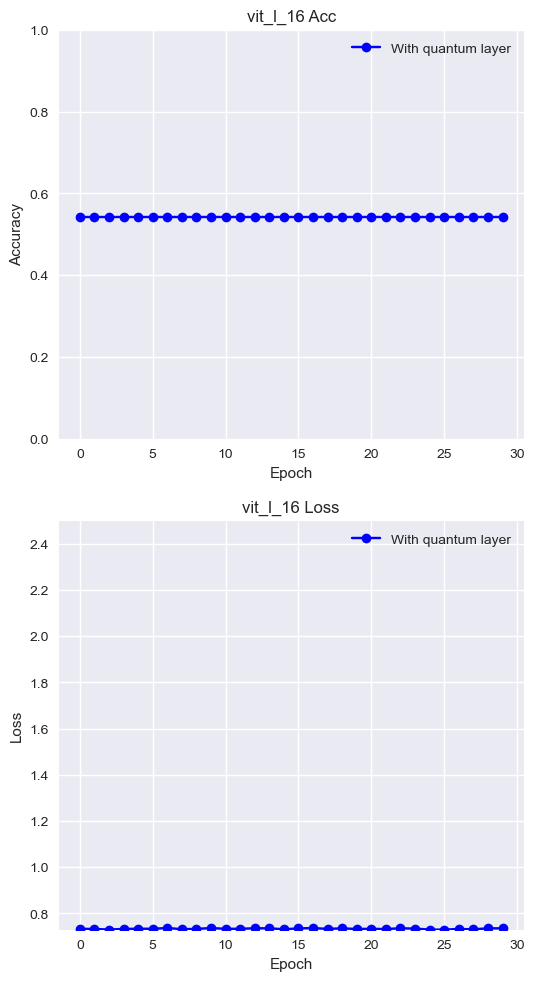

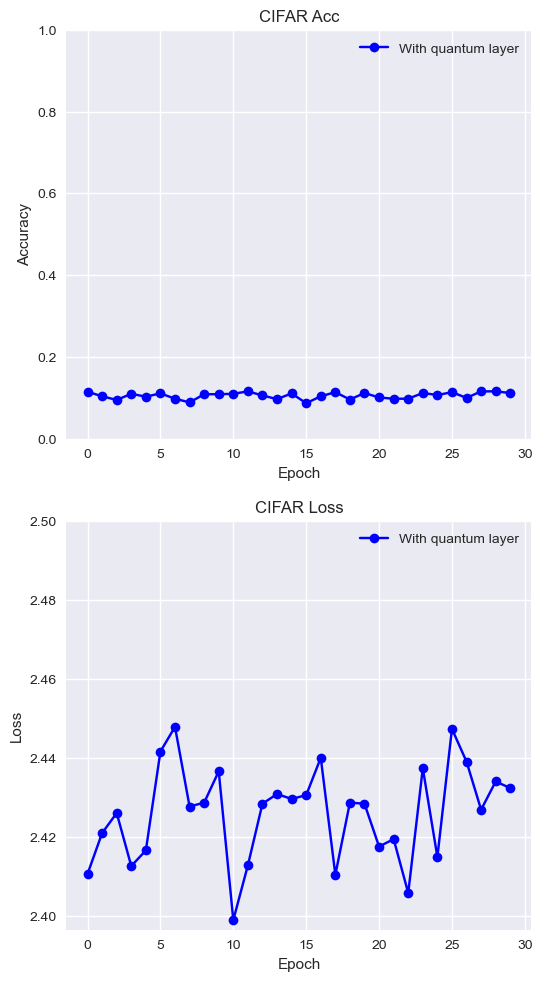

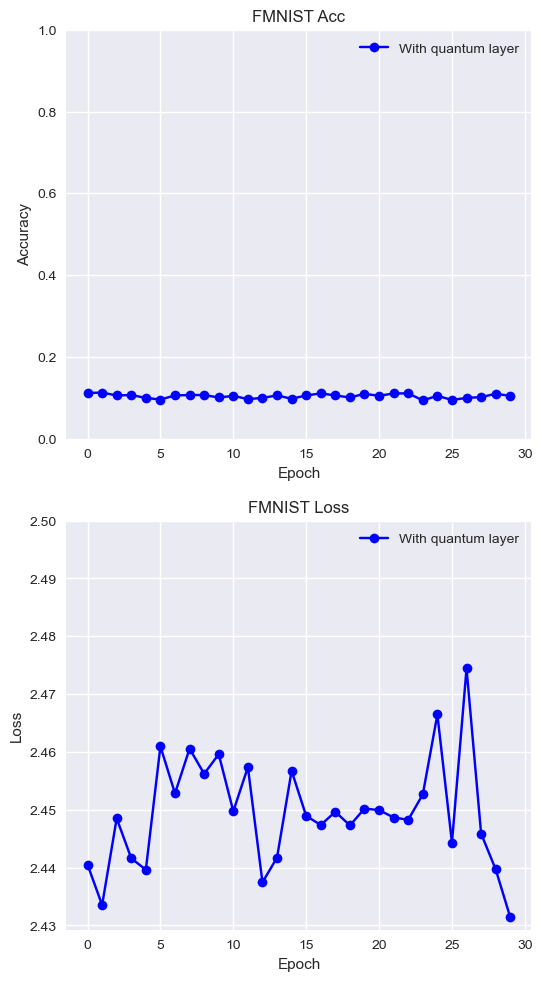

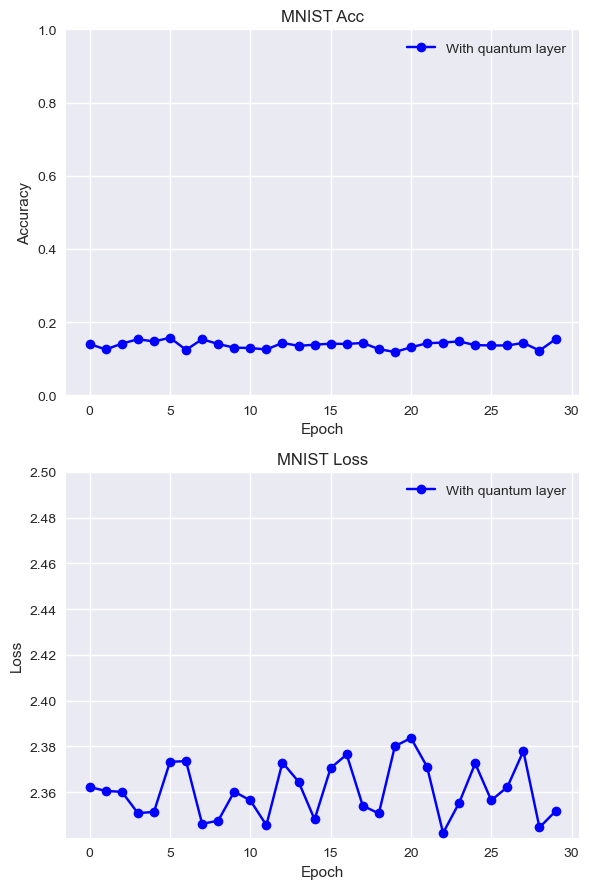

In [23]:
import matplotlib.pyplot as plt
%matplotlib inline

# виведення графіків результатів
plt.style.use("seaborn")
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 9))


ax1.plot(data_bees["acc"], "-ob", label="With quantum layer")
ax1.set_ylabel("Accuracy")
ax1.set_ylim([0, 1])
ax1.set_xlabel("Epoch")
ax1.set_title("vit_l_16 Acc")
ax1.legend()

ax2.plot(data_bees["loss"], "-ob", label="With quantum layer")
ax2.set_ylabel("Loss")
ax2.set_ylim(top=2.5)
ax2.set_xlabel("Epoch")
ax2.set_title("vit_l_16 Loss")
ax2.legend()
plt.subplots_adjust(bottom=1, top=2)


fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 9))


ax1.plot(data_CIFAR["acc"], "-ob", label="With quantum layer")
ax1.set_ylabel("Accuracy")
ax1.set_ylim([0, 1])
ax1.set_xlabel("Epoch")
ax1.set_title("CIFAR Acc")

ax1.legend()

ax2.plot(data_CIFAR["loss"], "-ob", label="With quantum layer")
ax2.set_ylabel("Loss")
ax2.set_ylim(top=2.5)
ax2.set_xlabel("Epoch")
ax2.set_title("CIFAR Loss")
ax2.legend()
plt.subplots_adjust(bottom=1, top=2)

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 9))

ax1.plot(data_FMNIST["acc"], "-ob", label="With quantum layer")
ax1.set_ylabel("Accuracy")
ax1.set_ylim([0, 1])
ax1.set_xlabel("Epoch")
ax1.set_title("FMNIST Acc")

ax1.legend()

ax2.plot(data_FMNIST["loss"], "-ob", label="With quantum layer")
ax2.set_ylabel("Loss")
ax2.set_ylim(top=2.5)
ax2.set_xlabel("Epoch")
ax2.set_title("FMNIST Loss")
ax2.legend()

plt.subplots_adjust(bottom=1, top=2)

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 9))

ax1.plot(data_MNIST["acc"], "-ob", label="With quantum layer")
ax1.set_ylabel("Accuracy")
ax1.set_ylim([0, 1])
ax1.set_xlabel("Epoch")
ax1.set_title("MNIST Acc")

ax1.legend()

ax2.plot(data_MNIST["loss"], "-ob", label="With quantum layer")
ax2.set_ylabel("Loss")
ax2.set_ylim(top=2.5)
ax2.set_xlabel("Epoch")
ax2.set_title("MNIST Loss")
ax2.legend()

plt.subplots_adjust(bottom=1, top=2)



plt.tight_layout()
plt.show()

In [24]:
def visualize_model(model, num_images=6, fig_name="Predictions", dataloaders=dataloaders, class_names=class_names):
    images_so_far = 0
    _fig = plt.figure(fig_name)
    model.eval()
    with torch.no_grad():
        for _i, (inputs, labels) in enumerate(dataloaders["validation"]):
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images // 2, 2, images_so_far)
                ax.axis("off")
                ax.set_title("[{}]".format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])
                if images_so_far == num_images:
                    return

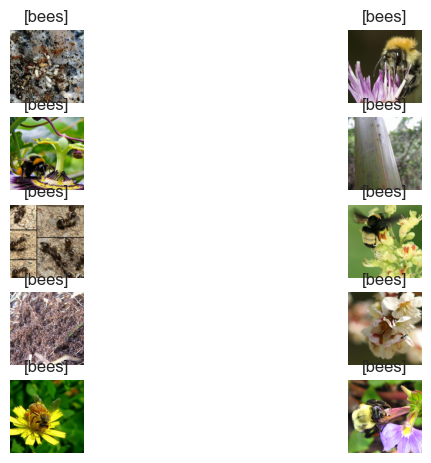

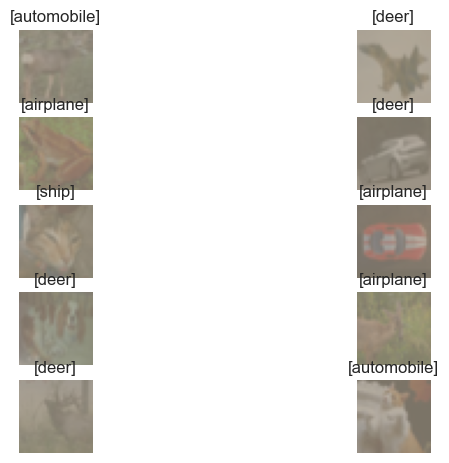

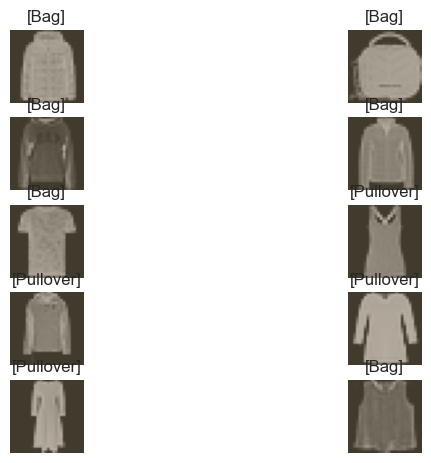

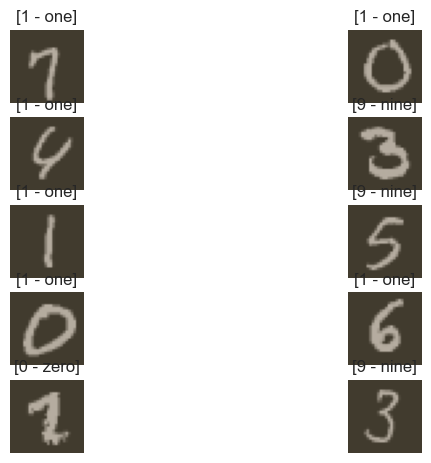

In [25]:
visualize_model(model_hybrid, num_images=10, dataloaders=dataloaders, class_names=class_names)

plt.show()
visualize_model(model_hybrid_CIFAR, num_images=10, dataloaders=dataloaders_CIFAR, class_names=class_names_CIFAR)

plt.show()
visualize_model(model_hybrid_FMNIST, num_images=10, dataloaders=dataloaders_FMNIST, class_names=class_names_FMNIST)

plt.show()
visualize_model(model_hybrid_MNIST, num_images=10, dataloaders=dataloaders_MNIST, class_names=class_names_MNIST)

plt.show()
